In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [4]:
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
os.makedirs('model_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.batch_size = 512
    self.num_epochs = 25
    self.save_folder = 'CNN_LSTM'
    
    self.subsequences = self.train_seq_len//(12*24)
    self.conv_num_channels = 128
    self.pool_size = 2
    self.lstm_hidden_dim = 100

In [0]:
args = Args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
#scaler.inverse_transform(train)

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [14]:
X_train, y_train = make_windows(train_df)

100%|██████████| 69697/69697 [00:12<00:00, 5617.15it/s]


In [15]:
X_val, y_val = make_windows(val_df)

100%|██████████| 12097/12097 [00:01<00:00, 7372.54it/s]


In [24]:
X_train = X_train.reshape(X_train.shape[0], args.subsequences, -1, 1)
X_train.shape

(69697, 7, 288, 1)

In [25]:
X_val = X_val.reshape(X_val.shape[0], args.subsequences, -1, 1)
X_val.shape

(12097, 7, 288, 1)

In [0]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters = args.conv_num_channels, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train.shape[2], 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size = args.pool_size)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(args.lstm_hidden_dim, activation = 'relu'))
model.add(Dense(args.val_seq_len))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 288, 128)    256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 144, 128)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 18432)       0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               7413200   
_________________________________________________________________
dense_1 (Dense)              (None, 288)               29088     
Total params: 7,442,544
Trainable params: 7,442,544
Non-trainable params: 0
_________________________________________________________________


In [0]:
sgd = optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [0]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
best_val = ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [26]:
history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop, best_val], verbose=1)

Train on 69697 samples, validate on 12097 samples
Epoch 1/25
69697/69697 [==============================] - 20s 284us/step - loss: 0.0427 - val_loss: 0.0200
Epoch 2/25
69697/69697 [==============================] - 12s 179us/step - loss: 0.0198 - val_loss: 0.0189
Epoch 3/25
69697/69697 [==============================] - 13s 182us/step - loss: 0.0189 - val_loss: 0.0180
Epoch 4/25
69697/69697 [==============================] - 13s 181us/step - loss: 0.0180 - val_loss: 0.0172
Epoch 5/25
69697/69697 [==============================] - 13s 182us/step - loss: 0.0173 - val_loss: 0.0165
Epoch 6/25
69697/69697 [==============================] - 13s 182us/step - loss: 0.0167 - val_loss: 0.0159
Epoch 7/25
69697/69697 [==============================] - 13s 180us/step - loss: 0.0162 - val_loss: 0.0154
Epoch 8/25
69697/69697 [==============================] - 13s 180us/step - loss: 0.0158 - val_loss: 0.0150
Epoch 9/25
69697/69697 [==============================] - 13s 180us/step - loss: 0.0154 - val_

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

25

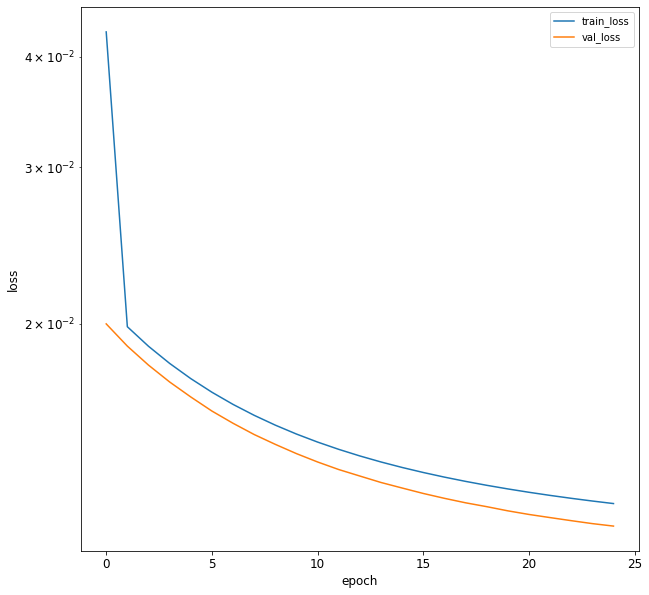

In [28]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.savefig('plots/'  + args.save_folder + '/train_val_loss.png')
plt.show()

In [29]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 7545.40it/s]


In [30]:
X_test = X_test.reshape(X_test.shape[0], args.subsequences, -1, 1)
X_test.shape

(12097, 7, 288, 1)

In [0]:
y_pred = model.predict(X_test)

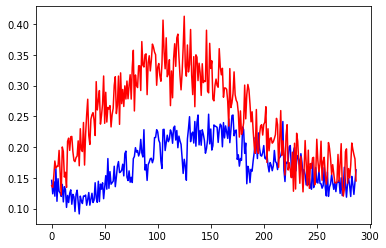

In [36]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred[0], color = 'red')
plt.savefig('plots/' + args.save_folder + '/test_weekend_pred.png')

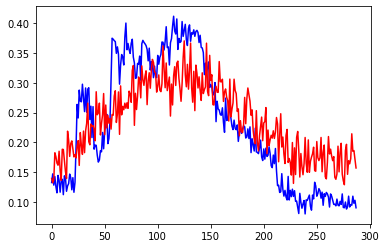

In [37]:
plt.plot(y_test[12*24], color = 'blue')
plt.plot(y_pred[12*24], color = 'red')
plt.savefig('plots/'  + args.save_folder + '/test_weekday_pred.png')

In [0]:
if not os.path.exists('results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2'])  
else:
  results = po.read_csv('results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [40]:
results

,model,MAE,MSE,R2
0,Dilated_CNN,0.042400,0.003150,0.679306
1,vanillaLSTM,0.134216,0.022371,-1.277546
2,CNN_LSTM,0.059652,0.005216,0.469051
3,bidirectionalLSTM,0.126920,0.020101,-1.046449
4,CNN_LSTM,0.066086,0.006133,0.375636
5,convLSTM,0.040161,0.002803,0.714712
6,Dilated_CNN,0.037945,0.002629,0.732376
7,stackedGRU,0.134907,0.022578,-1.298547
8,vanillaWaveNet,0.047592,0.003554,0.638191
9,vanillaWaveNet_256_channels,0.046997,0.003457,0.648037


In [0]:
results.to_csv('results.csv', index=False)

In [0]:
with open('model_checkpoints/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()

In [0]:
if not os.path.exists('forecasts/full_testing_length/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [45]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,Dilated_CNN,0.037945,0.002629,0.732376,3.794527,0.051273
1,vanillaWaveNet_256_channels,0.046997,0.003457,0.648037,4.699682,0.058799
2,convLSTM,0.040161,0.002803,0.714712,4.016132,0.052941
3,bidirectionalLSTM,0.126920,0.020101,-1.046449,12.691955,0.141780
4,WaveNet,0.049359,0.004077,0.585029,4.935853,0.063849
5,vanillaLSTM,0.134216,0.022371,-1.277546,13.421554,0.149570
6,CNN_LSTM,0.064756,0.005974,0.391845,6.475569,0.077294
7,CNN_LSTM,0.064756,0.005974,0.391845,6.475569,0.077294


In [0]:
results.to_csv('forecasts/full_testing_length/results.csv', index=False)